In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import datetime
from datetime import timedelta
import ast
import json    
import missingno as msno
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Helper packages
from plotnine import *

# Modeling packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [377]:
df = pd.read_csv('../data/tryML.csv')
df['user_id'] = df['user_id'].astype('object')

In [378]:
df.columns

Index(['user_id', 'id', 'len_of_title', 'price', 'len_of_content',
       'img_in_posd', 'beds', 'livings', 'wc', 'area', 'street_width', 'age',
       'ketchen', 'ac', 'furnished', 'user', 'district', 'advertiser_type',
       'review', 'profileImg', 'iam_verified', 'rega_id', 'DayOfRent',
       'timeBeforeRent', 'onMarket', 'zone', 'createYEAR', 'createMONTH',
       'createDAY', 'lUpdateYEAR', 'lUpdateMONTH', 'lUpdateDAY', 'isRent'],
      dtype='object')

after impliminting the ML model i decided to drop the creation and update column

In [379]:
df.drop(['createYEAR'],axis=1 ,inplace=True)
df.drop(['createDAY'],axis=1 ,inplace=True)
df.drop(['createMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateDAY'],axis=1 ,inplace=True)
df.drop(['lUpdateMONTH'],axis=1 ,inplace=True)
df.drop(['lUpdateYEAR'],axis=1 ,inplace=True)

## ready for Pipeline

delete low varince and outliers 

In [380]:
df =df[df['beds'] <=5]
df = df.loc[(df['review'] > 3) | (df['review'] == 1)]
df = df[df['price'] <=100*1000]

In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 6170
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          5992 non-null   object 
 1   id               5992 non-null   int64  
 2   len_of_title     5992 non-null   int64  
 3   price            5992 non-null   int64  
 4   len_of_content   5992 non-null   int64  
 5   img_in_posd      5992 non-null   int64  
 6   beds             5992 non-null   int64  
 7   livings          5992 non-null   float64
 8   wc               5992 non-null   int64  
 9   area             5992 non-null   float64
 10  street_width     5992 non-null   float64
 11  age              5992 non-null   float64
 12  ketchen          5992 non-null   float64
 13  ac               5992 non-null   float64
 14  furnished        5992 non-null   float64
 15  user             5992 non-null   object 
 16  district         5992 non-null   object 
 17  advertiser_typ

In [382]:
nzv = VarianceThreshold(threshold=0.1)

dealing with Skewness

In [383]:
yj = PowerTransformer(method="yeo-johnson")
# X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

Standardization

In [384]:
scaler = StandardScaler()


# standardize all numeric features
# std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

OneHotEncoder for advertiser_type

In [385]:
encoder = OneHotEncoder(handle_unknown="ignore")


pca to try if it going to help 

In [386]:
# pca = PCA(n_components=14)


In [387]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [388]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('nzv_encode', VarianceThreshold(threshold=0.1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f531e4dca60>),
                                ('norm', PowerTransformer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f531e4dc1c0>),
                                ('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f531e4dcd30>),
                                ('one-hot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f531e4dc940>)])

here i dropped DayOfRent becouse `isRent` is dependent on `DayOfRent` so there is no meaning on adding it (bias)

`timeBeforeRent` is also depedns on DayOfRent (dayOFrent - createDate)

for the `id`  when use it the accuracy increae ( becouse it is orderd)  as you can see 

In [389]:
temp = pd.read_csv('../data/aqar.csv')
temp[['id' , 'create_time'] ].sort_values(by='id')

,id,create_time
3866,211899,"['2016-05-26', '15:44:24']"
3830,779331,"['2017-11-23', '16:28:34']"
1703,825676,"['2017-12-30', '16:06:27']"
557,879567,"['2018-02-08', '19:20:10']"
533,1269068,"['2018-11-28', '16:02:25']"
...,...,...
491,4600178,"['2022-08-06', '12:05:24']"
1635,4600194,"['2022-08-06', '12:11:55']"
6710,4600222,"['2022-08-06', '12:21:15']"
26,4600237,"['2022-08-06', '12:24:50']"


we can see that the first id has the oldest creation date and the last id has the  date of my webscraping

but the reason of droping the value are they dont help the `project` 

even though it increases the accuracy but what i want to build is depending about the apartment you have and the featurs of the apartment (the age , the bedrooms , the price you want ... etc ) and i can't ask the user what is your id  and the same for `oMarket` feature i can't ask the user to enter how long it was in the market the user should use the model before he/she put it in the market 

In [390]:
df = df.drop(['user','rega_id'] , axis=1)

In [391]:
# X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket'  ] , axis=1)
X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket' ,'profileImg', 'iam_verified' , 'user_id' ] , axis=1)

y = df['isRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# training & prediction


k-fold = 5
loss function = accurcy 

In [328]:
loss = 'accuracy'
k = 5 #k-fold

# logistic Regerssion

In [329]:
lr = LogisticRegression(max_iter=500)

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("lr", lr),
])

In [330]:
cb_reg_1 = model_pipeline.fit(X_train , y_train)

In [331]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

0.5923491179201485

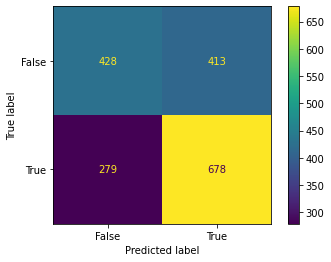

In [332]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

In [333]:
print(classification_report(y_test,  model_pipeline.predict(X_test), target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.61      0.51      0.55       841
         pos       0.62      0.71      0.66       957

    accuracy                           0.62      1798
   macro avg       0.61      0.61      0.61      1798
weighted avg       0.61      0.62      0.61      1798



In [334]:
# # Helper packages
# import numpy as np
# import pandas as pd
# from plotnine import *
# from scipy.stats import uniform
# from scipy.stats import randint

# # Modeling packages
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from category_encoders.ordinal import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.compose import make_column_selector as selector
# from sklearn.compose import ColumnTransformer
# from sklearn.compose import make_column_selector as selector
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.inspection import partial_dependence
# from sklearn.pipeline import Pipeline

# Random Forest


In [335]:
rf_mod = RandomForestClassifier()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

In [336]:
cb_reg_1 = model_pipeline.fit(X_train , y_train)

In [337]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

0.6762890745899102

In [338]:
model_pipeline.score(X_test , y_test)

0.710789766407119

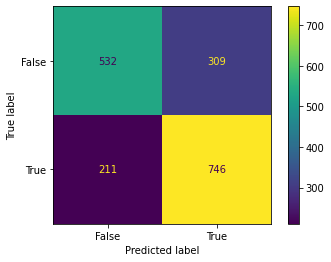

In [339]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

In [340]:
print(classification_report(y_test,  model_pipeline.predict(X_test), target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.72      0.63      0.67       841
         pos       0.71      0.78      0.74       957

    accuracy                           0.71      1798
   macro avg       0.71      0.71      0.71      1798
weighted avg       0.71      0.71      0.71      1798



In [170]:
r = permutation_importance(
  model_pipeline, 
  X_train, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
vip.sort_values()

KeyboardInterrupt: 

In [259]:
# df = df.drop(['user','rega_id'] , axis=1)

In [320]:
# X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket' ,'profileImg', 'iam_verified' , 'user_id' , 'price' ,'len_of_content' ,'review','area','img_in_posd' ,'age','street_width'] , axis=1)
# X = df.drop('.')
# X = df[['price' ,'len_of_content' ,'review','area','img_in_posd' ,'age','district' ,'zone']]
# y = df['isRent']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

 # Decision Tree 

In [189]:
rf_mod = DecisionTreeClassifier()

In [190]:
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

In [191]:
cb_reg_1  = model_pipeline.fit(X_train , y_train)

In [192]:
results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
np.abs(np.mean(results))

0.576716186939028

In [193]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))

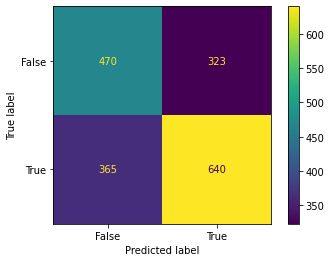

In [194]:
cm = confusion_matrix(y_test , model_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=model_pipeline.classes_
  )
  
disp.plot()

In [195]:
print(classification_report(y_test,  model_pipeline.predict(X_test), target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.56      0.59      0.58       793
         pos       0.66      0.64      0.65      1005

    accuracy                           0.62      1798
   macro avg       0.61      0.61      0.61      1798
weighted avg       0.62      0.62      0.62      1798



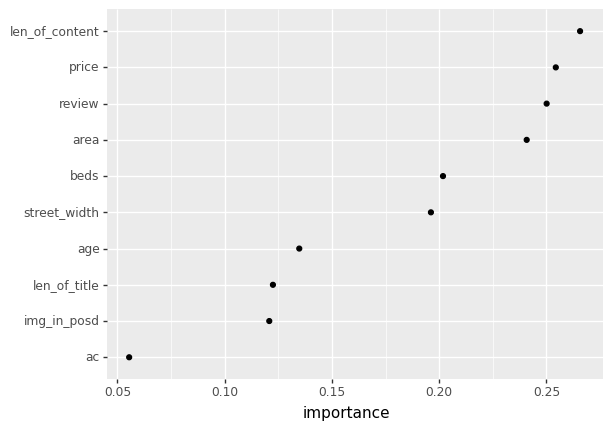

<ggplot: (8749757840237)>

In [196]:
r = permutation_importance(
  model_pipeline, 
  X_train, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

------

## i tried many models here and i used diffrent PCAs with cross validation

In [197]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
# from sklearn.linear_model import BaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold

In [198]:
X_train.shape

(4194, 10)

In [199]:

parameters = {
    'n_estimators'      : [320,330,340 , 400 , 500 , 600 , 700],
    'max_depth'         : [8, 9, 10, 11, 12 , 20 , 30 ],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}

In [200]:
ax = pd.DataFrame()
ax['methodName'] = ''
ax['PCA'] = ''
ax['accurcy'] = ''
# X = df.drop(['isRent' , 'DayOfRent' , 'timeBeforeRent' ,  'id' , 'onMarket'  ] , axis=1)

# X = df[['price' , 'img_in_posd' ,'beds' ,'livings', 'wc', 'area', 'age' ,'ketchen', 'ac', 'furnished', 'district', 'advertiser_type', 'review', 'zone']]

# y = df['isRent']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
for i in range(5,50,2):
  
  try:
      # scaler = StandardScaler()
      # yj = PowerTransformer(method="yeo-johnson")
      # nzv = VarianceThreshold(threshold=0.1)
      # encoder = OneHotEncoder(handle_unknown="ignore")
      pca = PCA(n_components=i)
      # cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )


      # training & prediction
      preprocessor = ColumnTransformer(
        remainder="passthrough",
        transformers=[
        ("nzv_encode", nzv, selector(dtype_include="number")),
        ("norm", yj, selector(dtype_include="number")),
        ("std_encode", scaler, selector(dtype_include="number")),
        ("pca_encode", pca, selector(dtype_include="number")),
        ("one-hot", encoder, selector(dtype_include="object")),
        ])


      classifiers = [
          KNeighborsClassifier(3),
          SVC(kernel="rbf", C=0.025, probability=True),
          NuSVC(probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          ExtraTreesClassifier(),
          # SGDClassifier(),
          # Perceptron(),
          # LinearSVC(),
          LogisticRegressionCV(),
          PassiveAggressiveClassifier(),
          BernoulliNB(),
          LogisticRegression()
          
          ]

      # Logging for Visual Comparison
      log_cols=["Classifier", "Accuracy", "Log Loss"]
      log = pd.DataFrame(columns=log_cols)

      for clf in classifiers:
          # clf1 = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
          
          model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", clf),
          ])
          model_pipeline.fit(X_train, y_train)
          name = clf.__class__.__name__
          results =cross_val_score(cb_reg_1, X_test, y_test.values.ravel(), cv=k, scoring=loss)
          acc = np.abs(np.mean(results))
          # print("="*30)
          # print(name)
          
          # print('****Results****')
          # train_predictions = model_pipeline.predict(X_test)
          # acc = accuracy_score(y_test, train_predictions)
          ax = ax.append({'methodName' : name , 'PCA' : i, 'accurcy' : acc*100}, ignore_index = True)
  except:
    i=23
        # print("Accuracy: {:.4%}".format(acc))
        
        # train_predictions = model_pipeline.predict_proba(X_test)
        # ll = log_loss(y_test, train_predictions)
        # print("Log Loss: {}".format(ll))
        
        # log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
        # log = log.append(log_entry)
        
        # print("="*30 , i,"PCA")

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_8550/2868628364.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

In [201]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),
  ("norm", yj, selector(dtype_include="number")),
  ("std_encode", scaler, selector(dtype_include="number")),
  # ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])


GaussianProcessClassifier
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
XGBClassifier

In [207]:
ax[ax['accurcy'] == ax['accurcy'].max()]


,methodName,PCA,accurcy
11,LogisticRegressionCV,5,59.007428


In [208]:
import plotly.express as px
# df = px.data.gapminder()
fig = px.scatter(ax, x="PCA", y="accurcy", color="methodName" , log_x=True, size_max=60)
fig.show()

In [209]:

parameters = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}

In [321]:
clf = RandomForestClassifier(n_estimators=300)
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("clf", clf),
])
clf1  = model_pipeline.fit(X_train, y_train)


In [322]:
results =cross_val_score(clf1, X_test, y_test.values.ravel(), cv=k, scoring=loss)

In [323]:
np.abs(np.mean(results))

0.6557257814917982

In [324]:
a = clf1.predict(X_test)
accuracy_score(y_test, a)

0.7163515016685206

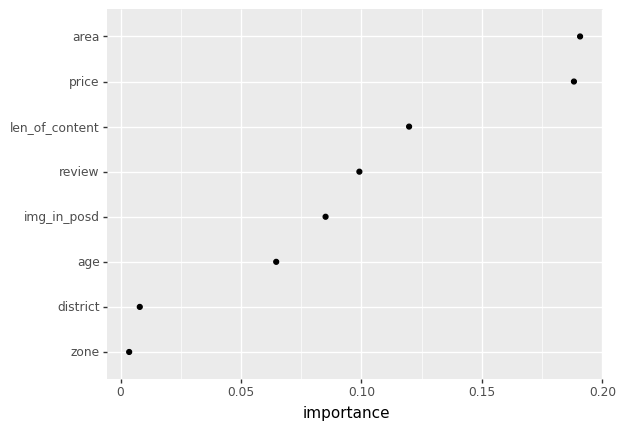

<ggplot: (8749750477347)>

In [325]:
r = permutation_importance(
  model_pipeline, 
  X_train, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

In [249]:
x= list(vip.sort_values(by='importance', ascending=False)['feature'].head(5))


In [250]:
x.append('district' )

In [251]:
x.append( 'zone')


In [215]:
# import joblib
# joblib.dump(clf1, "class.pkl")

# deep learning 

In [343]:
import os
import tensorflow as tf


In [371]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
# utility packages
import random


In [372]:
n = 1000   # n observations
b = 30     # intercept
a = 5      # slope

In [392]:
model = Sequential()
model.add(Dense(units=1, input_dim=1))

In [397]:
kr = model.compile(loss='mse', optimizer='sgd')

In [407]:
def create_tensor_dict(data, categorical_feature_names):
    inputs = {}
    for name, column in data.items():
      if type(column[0]) == str:
        dtype = tf.string
      elif (name in categorical_feature_names):
        dtype = tf.int64
      else:
        dtype = tf.float32

      inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
    return inputs

inputs = create_tensor_dict(X, ['district' , 'zone' , 'advertiser_type'])
print(inputs)

{'len_of_title': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'len_of_title')>, 'price': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'price')>, 'len_of_content': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'len_of_content')>, 'img_in_posd': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'img_in_posd')>, 'beds': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'beds')>, 'livings': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'livings')>, 'wc': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'wc')>, 'area': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'area')>, 'street_width': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'street_width')>, 'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>, 'ketchen': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'ketchen')>, 'ac': <KerasTensor: shape=(None,) dtype=float32 (created by layer '

In [401]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))
    return fun(values, axis=-1)

In [402]:
def create_normalizer(numeric_feature_names, data):
    numeric_features = data[numeric_feature_names]
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))  
    return normalizer

In [403]:
def normalize_numeric_input(numeric_feature_names, inputs, normalizer):
    numeric_inputs = {}
    for name in numeric_feature_names:
      numeric_inputs[name]=inputs[name]
    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs) 
    return numeric_normalized

In [405]:
X.columns

Index(['len_of_title', 'price', 'len_of_content', 'img_in_posd', 'beds',
       'livings', 'wc', 'area', 'street_width', 'age', 'ketchen', 'ac',
       'furnished', 'district', 'advertiser_type', 'review', 'zone'],
      dtype='object')

In [412]:
normalizer = create_normalizer(['len_of_title', 'price', 'len_of_content', 'img_in_posd', 'beds',
       'livings', 'wc', 'area', 'street_width', 'age', 'ketchen', 'ac',
       'furnished',   'review'], X)
numeric_normalized = normalize_numeric_input(['len_of_title', 'price', 'len_of_content', 'img_in_posd', 'beds',
       'livings', 'wc', 'area', 'street_width', 'age', 'ketchen', 'ac',
       'furnished',   'review'], inputs, normalizer)
print(numeric_normalized)

KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")


In [409]:
preprocessed = []
preprocessed.append(numeric_normalized)

In [410]:
def one_hot_encode_categorical_features(categorical_feature_names, data, inputs):
    one_hot = []
    for name in categorical_feature_names:
      value = sorted(set(data[name]))

      if type(value[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=value, output_mode='one_hot')
      else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=value, output_mode='one_hot')

      x = inputs[name][:, tf.newaxis]
      x = lookup(x)
      one_hot.append(x)
    return one_hot

In [413]:
one_hot = one_hot_encode_categorical_features( ['district' , 'zone' , 'advertiser_type'], X, inputs)
preprocessed = preprocessed + one_hot
print(preprocessed)

[<KerasTensor: shape=(None, 14) dtype=float32 (created by layer 'normalization')>, <KerasTensor: shape=(None, 127) dtype=float32 (created by layer 'string_lookup')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'string_lookup_2')>]


In [414]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
print(preprocesssed_result)

KerasTensor(type_spec=TensorSpec(shape=(None, 152), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")


In [415]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

In [416]:
preprocessor(dict(X.iloc[:1]))


<tf.Tensor: shape=(1, 152), dtype=float32, numpy=
array([[ 0.6329725 , -0.6062512 , -0.15302105,  0.41011822, -0.27066255,
         0.3683173 , -2.4247572 ,  2.1927073 ,  0.7889201 ,  0.02947097,
         2.3161383 ,  0.05866187, -1.3480737 ,  1.0280122 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
 

In [417]:
network = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [418]:
x = preprocessor(inputs)
result = network(x)
model = tf.keras.Model(inputs, result)

In [419]:
model.compile(loss='binary_crossentropy', optimizer='sgd',
                metrics=['accuracy'])

In [420]:
history = model.fit(dict(X), y, epochs=50, batch_size=8)

Epoch 1/50
749/749 [==============================] - 1s 1ms/step - loss: 0.7496 - accuracy: 0.5576
Epoch 2/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6613 - accuracy: 0.6076
Epoch 3/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6679 - accuracy: 0.6153
Epoch 4/50
749/749 [==============================] - 1s 2ms/step - loss: 0.6493 - accuracy: 0.6247
Epoch 5/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6439 - accuracy: 0.6315
Epoch 6/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6372 - accuracy: 0.6312
Epoch 7/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6325 - accuracy: 0.6424
Epoch 8/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6282 - accuracy: 0.6434
Epoch 9/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6807 - accuracy: 0.6175
Epoch 10/50
749/749 [==============================] - 1s 1ms/step - loss: 0.6484 - accuracy: 0.6282